# A first finite element code

In this notebook we will develop a one-dimensional finite Galerkin finite
element code.

```{note}
This notebook is incomplete and will be completed as an exercise in class.
```

## Basic algorithm

Recall that using the notions in {doc}`part1` and during class we derived the
following expressions for the entries of the finite element stiffness matrix
$\mathbf{K}$ and load vector $\mathbf{f}$

$$
K_{ij} &:= \sum_{K \in \mathcal{T}_h} \int_{K} \nabla \phi_i \cdot \nabla \phi_j \; \mathrm{d}x, \\
f_{j} &:= \sum_{K \in \mathcal{T}_h} \int_{K} f \phi_j \; \mathrm{d}x.
$$

Instead of calculating each entry of $K_{ij}$ we discussed that the most
straightforward way to *assemble* the stiffness matrix is to:
1. Loop over the global cells $K$ of the mesh $\mathcal{T}_h$.
2. Calculate the cell local contribution $\mathbf{K}_K \in \mathbb{R}^{2
\times 2}$.
3. Determine which pair of finite element basis functions are active on the
   cell.
4. *Assemble* (add) the cell local contribution to the stiffness matrix at
   the location of the active basis functions.

The load vector assembly follows similarly.

### Exercise 1

For a general cell $K$ derive an explicit symbolic expression for the cell
local contribution $\mathbf{K}_K \in \mathbb{R}^{2 \times 2}$ in terms of
$h$. Use the local-to-global mapping approach shown in class.


### ---> Solution: 

The standard linear basis functions is used for  $K = [x_i, x_{i+1}]$ of length $h = x_{i+1} - x_i$ (a general cell)

$$
\phi_0(x) = \frac{x_{i+1} - x}{h}, \quad \phi_1(x) = \frac{x - x_i}{h}.
$$

Their derivatives are constant:

$$
\phi_0'(x) = -\frac{1}{h}, \quad \phi_1'(x) = \frac{1}{h}.
$$

the entries of the local stiffness matrix:

- Diagonal terms:
$$
\int_K (\phi_0')^2 \, dx = \int_K (\phi_1')^2 \, dx = \frac{1}{h},
$$

- Off-diagonal terms:
$$
\int_K \phi_0' \phi_1' \, dx = -\frac{1}{h}.
$$

the local stiffness matrix:

$$
\mathbf{K}_K = \frac{1}{h}
\begin{bmatrix}
1 & -1 \\
-1 & 1
\end{bmatrix}.
$$



### Exercise 2

Complete the function `cell_stiffness` which returns the stiffness matrix for
a cell with vertices $a$ and $b$ with $b > a$.


In [43]:
# Import necessary libraries
import numpy as np
import numpy.typing as npt
import matplotlib.pyplot as plt
from typing import NamedTuple, Callable

# Define a named tuple for the mesh
def cell_stiffness(a: float, b: float) -> npt.NDArray[np.float64]:

    """Calculate the stiffness matrix contribution for a cell with vertices a and b.

    Args:
        a: Position of first vertex.
        b: Position of second vertex.

    Return:
        The stiffness matrix contribution for the cell.
    """
    # Ensure that a < b
    assert b > a
    h = b - a  

    # Calculate the stiffness matrix for a linear element
    # The stiffness matrix for a linear element is constant and given by:
    # K = [[1/h, -1/h], [-1/h, 1/h]] (As per the ex 1)
    return np.array([[1/h, -1/h], 
                    [-1/h, 1/h]], dtype=np.float64) 

# Example usage of the cell_stiffness function
stiffness = cell_stiffness(0.0, 1.0)
assert stiffness.shape == (2, 2)
print("Cell stiffness matrix for h=1:\n", stiffness)

Cell stiffness matrix for h=1:
 [[ 1. -1.]
 [-1.  1.]]



## Mesh

The mesh will be composed of two data structures:
1. the *geometry* which will contain the positions of the vertices of the
mesh. The index on the first dimension (rows) is the mesh vertex number. The
index on the second dimension (columns) of the geometry is the related to the
coordinate index.
2. the *topology*, which will contain the cell-to-vertex connectivity. The
index on the first dimension (rows) is the cell number. The index on the
second dimension (columns) are the indices of the vertices of the cell.

Consider the case when we want to create a mesh with $N = 4$ cells. Here the
geometry will be a two-dimensional numpy array containing

$$
\text{geometry} =
\begin{bmatrix}
0.0 \\
0.25 \\
0.5 \\
0.75 \\
1.0
\end{bmatrix},
$$

and the topology a two-dimensional numpy array containing

$$
\text{topology} =
\begin{bmatrix}
0 & 1 \\
1 & 2 \\
2 & 3 \\
3 & 4
\end{bmatrix}.
$$

### Exercise 3

Generalise the function `create_unit_interval_mesh` to arbitrary input
`num_cells`.

```{note}
To avoid object-oriented programming, but to still keep the code tidy, we
will use Python's namedtuple feature which allows tuples to have *named
fields*.
```


In [44]:
# Import necessary libraries
import numpy as np
import numpy.typing as npt
from typing import NamedTuple

# Define a named tuple to represent the mesh structure
Mesh = NamedTuple(
    "Mesh", (("geometry", npt.NDArray[np.float64]), ("topology", npt.NDArray[np.int32]))
)

# Function to create a uniform mesh on the unit interval [0, 1]
def create_unit_interval_mesh(num_cells: int) -> Mesh:
    """
    Generate a 1D uniform mesh on the unit interval [0, 1].
    
    Args:
        num_cells: Number of cells to divide the interval into
        
    Returns:
        Mesh: Contains geometry (vertex positions) and topology (cell connectivity)
    """
    # Validate the number of cells and ensure it's at least 1
    geometry = np.linspace(0,1,num_cells+1,dtype=np.float64).reshape(-1,1)
    v1 = np.linspace(0,num_cells-1,num_cells)
    v2 = np.linspace(1,num_cells,num_cells )
    topology = np.zeros((num_cells,2),dtype=np.int32)
    topology[:,0] = v1[:]
    topology[:,1] = v2[:]
    return Mesh(geometry=geometry, topology=topology)

# Example usage of the create_unit_interval_mesh function
num_cells = 4
c = 1.0 * np.pi # Example constant for testing
mesh = create_unit_interval_mesh(num_cells)
print(mesh)
if num_cells == 4:
    print(f"Mesh: {mesh}")
    assert np.all(np.isclose(mesh.geometry, [[0.0], [0.25], [0.5], [0.75], [1.0]]))
    assert np.all(np.isclose(mesh.topology, [[0, 1], [1, 2], [2, 3], [3, 4]]))




Mesh(geometry=array([[0.  ],
       [0.25],
       [0.5 ],
       [0.75],
       [1.  ]]), topology=array([[0, 1],
       [1, 2],
       [2, 3],
       [3, 4]], dtype=int32))
Mesh: Mesh(geometry=array([[0.  ],
       [0.25],
       [0.5 ],
       [0.75],
       [1.  ]]), topology=array([[0, 1],
       [1, 2],
       [2, 3],
       [3, 4]], dtype=int32))


For question number 3 I tried to use *np.arange* for *geometry* too, but I had error. Even with ai I got confused because the explenation wasn't clear for me.

For example, for the second cell we can get the connected global vertices using

In [45]:
# Print the load vector for the second cell in the mesh
print("Load vector for the second cell:")
print(mesh.topology[1])

Load vector for the second cell:
[1 2]


and the position of the vertices using

In [46]:
print(mesh.geometry[mesh.topology[1]])

[[0.25]
 [0.5 ]]


and assemble the local stiffness matrix contribution. The `*` unpacks the
entries of the two element array into two separate variables `a` and `b`.

In [47]:
# Printing the stiffness matrix for the second cell in the mesh
print("Stiffness matrix for the second cell:")
print(cell_stiffness(*mesh.geometry[mesh.topology[1]]))

Stiffness matrix for the second cell:
[[[ 4.]
  [-4.]]

 [[-4.]
  [ 4.]]]



## Degree of freedom map

The *degree of freedom map* `dofmap` will be an array contain information
about the connection between the local basis functions (degrees of freedom)
on the local cell and the global basis functions (degrees of freedom). On the
first dimension (rows) the index is the mesh cell number. On the second
dimension (columns) the index is the local degree of freedom number.

For the $P_1$ finite element space $V_h$ each vertex is assigned one global
degree of freedom. Each cell then has two global degrees of freedom. To
ensure $C^0$ continuity, vertices shared by a cell must share global degrees
of freedom.

This is infact nothing more than the existing `mesh.topology` array! We
simply make a copy and continue, but we explicitly use the right array, in
the right place.

We package up the `mesh`, `dofmap` and also make a record of the `size` of
the function space in a new `NamedTuple` object `FunctionSpace`.

```{note}
This explicit separation between mesh topology, geometry and solution degrees
of freedom is not necessary for this simple problem, but does mimic closer
how a real finite element code such as [FEniCSx](https://fenicsproject.org)
or [Firedrake](https://firedrakeproject.org) is organised.
```

In [48]:
# Here we define a function space based on the mesh
FunctionSpace = NamedTuple(
    "FunctionSpace",
    (
        ("mesh", Mesh),
        ("dofmap", npt.NDArray[np.int32]),
        ("size", npt.NDArray[np.int64]),
    ),
)
fs = FunctionSpace(mesh=mesh, dofmap=mesh.topology.copy(), size=mesh.geometry.shape[0])

For example, we can get the global degree of freedom for global cell 1
associated with local degree of freedom 0 using

In [49]:
print(fs.dofmap[1, 0])

1


## Assembly of $\mathbf{K}$

We now have everything we need to assemble $\mathbf{K}$. Because of the local
construction of the basis functions $\mathbf{K}$ will be sparse, i.e. the
majority of its entries will be zero.

The package `scipy.sparse` contains various efficient sparse data structures.
For simplicity I recommend building the sparse matrix in the [List of
Lists](https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.lil_matrix.html)
(LOL) format and then converting to the [Compressed Sparse
Row](https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.csr_matrix.html)
(CSR) format for efficient solution.

```{note} The
[COOrdinate](https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.coo_array.html#scipy.sparse.coo_array)
format is more efficient for construction than LOL. Constructing directly in
CSR is possible and is also the most efficient, but is significantly more complex.
```

### Exercise 4

Complete the function `assemble_stiffness`.

In [50]:
# Here we assemble the global stiffness matrix from the local stiffness matrices
def assemble_stiffness(
    fs: FunctionSpace, cell_stiffness_fn: Callable
) -> scipy.sparse.lil_matrix:
    
    """
    This function combines local stiffness matrices from each cell 
    into the global spare matrix that shows the global stiffness of the whole mesh.

    Args:
        fs: This keeps the mesh and DoF (degree of freedom) info that we need.
        cell_stiffness_fn: A function that gives the stiffness matrix for just one cell.

    Returns:
        The final global stiffness matrix in LIL format (sparse).
    
"""
    K = scipy.sparse.lil_matrix((fs.size, fs.size))

    # Loop over the cells of the mesh
    for cell in range(0, fs.mesh.topology.shape[0]):
        # Step 1: Calculate the stiffness matrix on this cell
        a, b = fs.mesh.geometry[fs.mesh.topology[cell]].flatten()
        K_local = cell_stiffness_fn(a, b)

        # Step 2: Extract the local to global degree of freedom mapping for the cell.
        dofs = fs.dofmap[cell]

        # Step 3: Scatter to the sparse matrix
        K[np.ix_(dofs, dofs)] += K_local
    return K


# Test
K = assemble_stiffness(fs, cell_stiffness)
if num_cells == 4:
    print(K)
    K_dense = K.todense()
    print(K_dense)
    assert np.all(np.isclose(K_dense, K_dense.T))


  (0, 0)	4.0
  (0, 1)	-4.0
  (1, 0)	-4.0
  (1, 1)	8.0
  (1, 2)	-4.0
  (2, 1)	-4.0
  (2, 2)	8.0
  (2, 3)	-4.0
  (3, 2)	-4.0
  (3, 3)	8.0
  (3, 4)	-4.0
  (4, 3)	-4.0
  (4, 4)	4.0
[[ 4. -4.  0.  0.  0.]
 [-4.  8. -4.  0.  0.]
 [ 0. -4.  8. -4.  0.]
 [ 0.  0. -4.  8. -4.]
 [ 0.  0.  0. -4.  4.]]


## Assembly of $\mathbf{f}$

We will now assemble the load vector $\mathbf{f}$.

If we take $f(x)$ as a general function then we cannot usually symbolically
calculate the cell local contribution $\mathbf{f}_{K}$ to the load vector
$\mathbf{f}$. A standard approach is to use quadrature, which allows the
approximation of an integral on the unit interval

$$
\int_0^1 g(\hat{x}) \approx \sum_{i = 0}^{n - 1} w_i g(\hat{x}^q_i),
$$

where the $w_i$ are known as the quadrature weights and the $\hat{x}_i^q$ as
quadrature points. We will use a two-point rule $n = 2$ on $[0, 1]$ with
points $\hat{x}^q_0 = \frac{1}{2} - \frac{1}{2\sqrt{3}}$ and $\hat{x}^q_1 =
\frac{1}{2} + \frac{1}{2\sqrt{3}}$ associated with weights $w_1 = w_2 =
\frac{1}{2}$.

```{note}
In a proper finite element code *both* the element contributions of the
stiffness matrix and load vector are calculated numerically through
[quadrature](https://en.wikipedia.org/wiki/Gaussian_quadrature).
```

This rule can be defined in code as

In [51]:
# Here we quadrature points and weights for a 1D Gauss-Legendre quadrature with 2 points
quadrature_points = np.array(
    [
        (1.0 / 2.0) - (1.0 / (2.0 * np.sqrt(3.0))),
        (1.0 / 2.0) + (1.0 / (2.0 * np.sqrt(3.0))),
    ]
)
# The quadrature points are the roots of the Legendre polynomial P_2(x) = 0
quadrature_weights = 0.5 * np.ones(2, dtype=np.float64)

print(quadrature_points[1])
print(quadrature_weights[1])

0.7886751345948129
0.5


### Exercise 6

Using the local-to-global approach and a quadrature rule with $n$ points
derive the cell local contribution $\mathbf{f}_K$ to the load vector
$\mathbf{f}$.


### Answer to Exercise 6 - 
#### ai helped me and for question I have to explain mathematics (like let sth be ...) still I have problems.


if $K = [a, b]$ be a cell with length $h = b - a$, it is possible to define the local load vector on this cell as:

$$
f_{K,j} = \int_K f(x) \, \varphi_j(x) \, dx, \quad j = 0, 1
$$

To make the integral simple (it never gets simple for me, anyways), I think I have to use $x = a + h\hat{x}$, which gives $dx = h \, d\hat{x}$ bacause I need to map $K$ to the reference element $[0,1]$ 

the basis functions on the reference element:

$$
\varphi_0(\hat{x}) = 1 - \hat{x}, \quad \varphi_1(\hat{x}) = \hat{x}
$$

Using an $n$-point quadrature rule:

$$
\int_0^1 g(\hat{x}) \, d\hat{x} \approx \sum_{i=0}^{n-1} w_i \, g(\hat{x}_i^q)
$$

the approximation:

$$
f_{K,j} \approx h \sum_{i=0}^{n-1} w_i \, f(a + h\hat{x}_i^q) \, \varphi_j(\hat{x}_i^q)
$$

And the full local vector is:

$$
\mathbf{f}_K = h
\begin{bmatrix}
\sum\limits_{i=0}^{n-1} w_i \, f(a + h\hat{x}_i^q)(1 - \hat{x}_i^q) \\
\sum\limits_{i=0}^{n-1} w_i \, f(a + h\hat{x}_i^q)\hat{x}_i^q
\end{bmatrix}
$$


### Exercise 7

Complete the functions `phi_hat` and `cell_load`. The latter returns the load
vector for a cell with vertices $a$ and $b$ with $b > a$.


In [52]:
# phi functions for local P1 finite element basis functions
def phi_hat(x_hat: float) -> npt.NDArray[np.float64]:

    """
    Calculate the local P1 finite element basis functions.

    Args:
        x_hat: Position in local element coordinate system.

    Returns:
        An array containing the evaluation of the local basis functions.
    """

    return np.array([1.0 - x_hat, x_hat], dtype=np.float64)         # phi_hat0 = 1 - x_hat , phi_hat1 = x_hat , on [0,1]


def cell_load(a: float, b: float, f: Callable = lambda x: 0.0) -> npt.NDArray[np.float64]: 

    """
    Compute the load vector for a single cell between a and b.

    Args:
        a: The first vertex position
        b: The second vertex position
        f: The forcing function we're integrating.

    Returns:
        the vector that gives the local contribution for the cell.
    """

    f_cell = np.zeros(2, dtype=np.float64)

    def exact(x):
        return (np.pi)**2 * np.sin(np.pi * x)

    # Loop over the quadrature points and weights
    # to compute the integral of f * phi_hat
    # We use the quadrature points and weights to approximate the integral
    for point, weight in zip(quadrature_points, quadrature_weights):
        x = a + (b - a) * point           
        phi = phi_hat(point)
        f_cell += (b - a) * weight * exact(x) * phi

    return f_cell
print(f' Output = {cell_load(0,1)}')

 Output = [3.04077828 3.04077828]


So for the second cell we can assemble the local stiffness matrix
contribution

In [53]:
print(cell_load(*mesh.geometry[mesh.topology[1]]))

[1.04934912 1.17189279]


In [54]:
# f is a function that we want to integrate over the cell
f = lambda x: np.sin(np.pi * x)
print(cell_load(0.25, 0.5, f))

[1.04934912 1.17189279]


### Exercise 8

Complete the function `assemble_load`.

In [55]:

# Assemble the load vector for the entire mesh 
def assemble_load(fs: FunctionSpace, cell_load_fn: Callable) -> npt.NDArray[np.float64]: 
    f = np.zeros(fs.size)

    # Loop over the cells of the mesh
    for cell in range(0, fs.mesh.topology.shape[0]):
        # Step 1: Calculate the stiffness matrix on this cell
        a, b = fs.mesh.geometry[fs.mesh.topology[cell]].flatten()
        f_local = cell_load_fn(a, b)
        # Step 2: Extract the local to global degree of freedom mapping for the
        # cell
        dofs = fs.dofmap[cell]
        # Step 3: Scatter to the vector
        f[dofs] += f_local
    return f

# fs = FunctionSpace(mesh=mesh, dofmap=mesh.topology.copy(), size=mesh.geometry.shape[0])
f = assemble_load(fs, cell_load)
if num_cells == 4:
    print(f)

[0.31211096 1.65730668 2.34378558 1.65730668 0.31211096]


## Applying Dirichlet conditions

We have assembled the matrix on the space $V_h$, but recall in the
specification of the weak form of the problem we used the space
$\mathring{V}_h$, that contains only the basis functions associated with the
interior degrees of freedom. We can transfer the problem to the space
$\mathring{V}_h$ by modifying the linear system in place. For the degrees of
freedom associated with vertices on the boundary (here, always $0$ and $N -
1$) we shall modify the stiffness matrix $\mathbf{K}$ by

1. placing $0$ on the corresponding rows,
2. placing $0$ on the corresponding columns,
3. inserting $1$ on the corresponding diagonals,

For the force vector $\mathbf{f}$ we place $0$ on the corresponding rows.


In [56]:

# Apply boundary conditions to the linear system (K, f)
def apply_boundary_conditions(
    dofs: npt.NDArray[np.int32], K: scipy.sparse.lil_matrix, f: npt.NDArray[np.float64]
):
    
    """Apply boundary conditions on dofs to the linear system (K, f).

    Note: K and f are modified in-place.

    Args:
        dofs: the degrees of freedom to apply boundary conditions to.
        K: the stiffness matrix.
        f: the force vector.
    """

    num_dofs = K.shape[0]

# Loop over the degrees of freedom to apply boundary conditions
    for dof in dofs:
        # Zero the row
        K.rows[dof] = []
        K.data[dof] = []

        # Loop over all the rows
        for row in range(num_dofs):
            if dof in K.rows[row]:
                idx = K.rows[row].index(dof)
                K.rows[row].pop(idx)
                K.data[row].pop(idx)

        K[dof, dof] = 1.0
        f[dof] = 0.0


boundary_dofs = np.array([0, mesh.geometry.shape[0] - 1], dtype=np.int32)
apply_boundary_conditions(boundary_dofs, K, f)

if num_cells == 4:
    print(K)
    print(f)

  (0, 0)	1.0
  (1, 1)	8.0
  (1, 2)	-4.0
  (2, 1)	-4.0
  (2, 2)	8.0
  (2, 3)	-4.0
  (3, 2)	-4.0
  (3, 3)	8.0
  (4, 4)	1.0
[0.         1.65730668 2.34378558 1.65730668 0.        ]


## Solving
We can now solve the system $\mathbf{K} \mathbf{u}_h = \mathbf{f}$ to find
the vector of previously unknown coefficients $\mathbf{u}_h$ of the finite
element solution $u_h$.

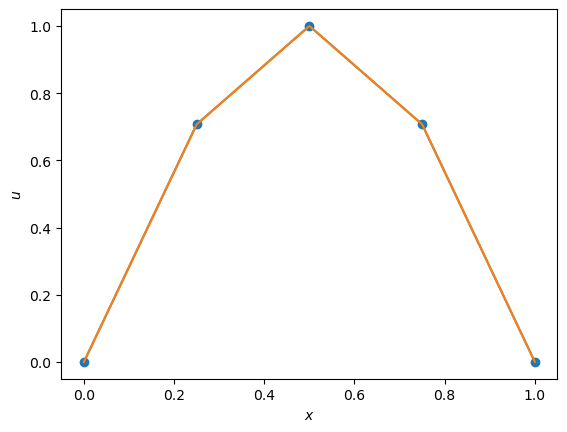

In [57]:
# K_csr is the sparse matrix in Compressed Sparse Row format
K_csr = K.tocsr()
u = scipy.sparse.linalg.spsolve(K_csr, f)

plt.plot(mesh.geometry, u, "o-")
plt.plot(mesh.geometry, np.sin(c * mesh.geometry), "-")
plt.xlabel(r"$x$")
plt.ylabel(r"$u$")
plt.show()

## Further exercises

### Exercise 9

Make a new function `cell_stiffness_quadrature` to compute the stiffness
matrix using a quadrature approach. Comment on the necessary order of the
quadrature rule to exactly compute the integrand. Pass this up to your
assembler and re-run, making sure you get the same result.


In [58]:

# Cell stiffness using quadrature is a more general approach that can be used for higher-order elements or different basis functions.
def cell_stiffness_quadrature(a: float, b: float) -> npt.NDArray[np.float64]:
    assert b > a, "Invalid cell: b must be greater than a"
    h = b - a
    dphi_dx = np.array([-1/h, 1/h])
    # Since gradient is constant, integral becomes:
    return np.outer(dphi_dx, dphi_dx) * h

# K_new = assemble_stiffness(fs, cell_stiffness_quadrature)
K_new = assemble_stiffness(fs, cell_stiffness_quadrature)
if num_cells == 4:
    print(f'K={K}')
    print(f'new K is equal to {K_new}')
    K_dense = K_new.todense()
    print(K_dense)
    assert np.all(np.isclose(K_dense, K_dense.T))


# Test: local matrix
print("Local stiffness matrix for cell [0, 1]:")
print(cell_stiffness_quadrature(0.0, 1.0))  # Expected: [[1, -1], [-1, 1]]

# Test: global matrix matches original
K_quadrature = assemble_stiffness(fs, cell_stiffness_quadrature)
K_original = assemble_stiffness(fs, cell_stiffness)
assert np.allclose(K_quadrature.todense(), K_original.todense()), "Quadrature stiffness matrix differs"
print("Global stiffness matrix from quadrature matches original!")

K=  (0, 0)	1.0
  (1, 1)	8.0
  (1, 2)	-4.0
  (2, 1)	-4.0
  (2, 2)	8.0
  (2, 3)	-4.0
  (3, 2)	-4.0
  (3, 3)	8.0
  (4, 4)	1.0
new K is equal to   (0, 0)	4.0
  (0, 1)	-4.0
  (1, 0)	-4.0
  (1, 1)	8.0
  (1, 2)	-4.0
  (2, 1)	-4.0
  (2, 2)	8.0
  (2, 3)	-4.0
  (3, 2)	-4.0
  (3, 3)	8.0
  (3, 4)	-4.0
  (4, 3)	-4.0
  (4, 4)	4.0
[[ 4. -4.  0.  0.  0.]
 [-4.  8. -4.  0.  0.]
 [ 0. -4.  8. -4.  0.]
 [ 0.  0. -4.  8. -4.]
 [ 0.  0.  0. -4.  4.]]
Local stiffness matrix for cell [0, 1]:
[[ 1. -1.]
 [-1.  1.]]
Global stiffness matrix from quadrature matches original!


### Exercise 10

Write a function `solve` which takes the `num_cells` (number of cells) as an
argument. Return the solution from the function. Plot a sequence of solutions
on increasingly fine meshes.


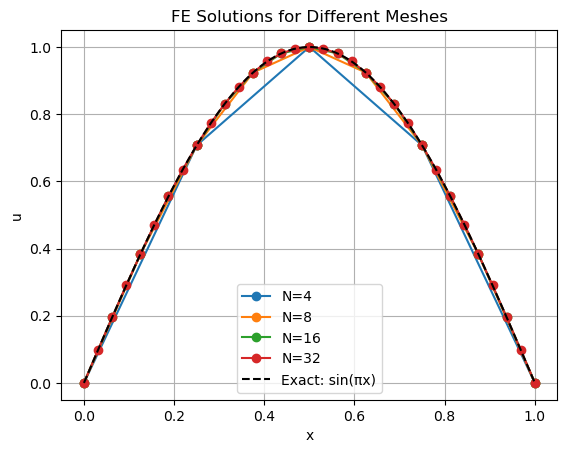

In [59]:
# Import necessary libraries for solving the Poisson equation
import numpy as np
import numpy.typing as npt
import scipy.sparse
import matplotlib.pyplot as plt
from typing import Callable

# Apply boundary conditions
def apply_boundary_conditions(
    dofs: npt.NDArray[np.int32], K: scipy.sparse.lil_matrix, f: npt.NDArray[np.float64]
):
    
    """
    Apply Dirichlet boundary conditions (set to zero) on specified dofs to the linear system (K, f).
    
    Note: K and f are modified in-place.
    
    Args:
        dofs: Degrees of freedom to apply boundary conditions to.
        K: Stiffness matrix (sparse LIL format).
        f: Load vector.
    """
# Ensure K is in LIL format
    num_dofs = K.shape[0]
    for dof in dofs:
        K.rows[dof] = []
        K.data[dof] = []
        for row in range(num_dofs):
            if dof in K.rows[row]:
                idx = K.rows[row].index(dof)
                K.rows[row].pop(idx)
                K.data[row].pop(idx)
        K[dof, dof] = 1.0
        f[dof] = 0.0

# Exercise 10: Solve function
def solve(num_cells: int, f: Callable = lambda x: np.pi**2 * np.sin(np.pi * x)) -> npt.NDArray[np.float64]:
    """
    Solve the 1D Poisson equation -u'' = f on [0, 1] with Dirichlet BCs u(0) = u(1) = 0
    using the finite element method with linear elements.

    Args:
        num_cells: Number of cells in the uniform mesh.
        f: Forcing function (default: pi^2 * sin(pi * x), for exact solution u(x) = sin(pi * x)).

    Returns:
        NumPy array containing the finite element solution u_h at mesh vertices.
    """
    # Create mesh and function space
    mesh = create_unit_interval_mesh(num_cells)
    fs = FunctionSpace(mesh=mesh, dofmap=mesh.topology.copy(), size=mesh.geometry.shape[0])
    
    # Assemble stiffness matrix
    K = assemble_stiffness(fs, cell_stiffness)
    
    # Assemble load vector
    f_vec = assemble_load(fs, lambda a, b: cell_load(a, b, f))
    
    # Apply Dirichlet boundary conditions
    boundary_dofs = np.array([0, fs.size - 1], dtype=np.int32)
    apply_boundary_conditions(boundary_dofs, K, f_vec)
    
    # Solve the system
    K_csr = K.tocsr()
    u = scipy.sparse.linalg.spsolve(K_csr, f_vec)
    
    return u

# Plot solutions for different meshes
num_cells_list = [4, 8, 16, 32]
plt.figure()
for nc in num_cells_list:
    mesh = create_unit_interval_mesh(nc)
    u = solve(nc)
    plt.plot(mesh.geometry, u, 'o-', label=f'N={nc}')

# Plot exact solution
x_fine = np.linspace(0, 1, 100)
u_exact = np.sin(np.pi * x_fine)
plt.plot(x_fine, u_exact, 'k--', label='Exact: sin(πx)')

plt.legend()
plt.title('FE Solutions for Different Meshes')
plt.xlabel('x')
plt.ylabel('u')
plt.grid(True)
plt.show()

In [60]:
# Defining assemble functions for stiffness and load with changed cell functions
def assemble_stiffness_changed(
    fs: FunctionSpace, cell_stiffness_fn: Callable
) -> scipy.sparse.lil_matrix:
    K = scipy.sparse.lil_matrix((fs.size, fs.size))

    for cell in range(fs.mesh.topology.shape[0]):
        a, b = fs.mesh.geometry[fs.mesh.topology[cell]].flatten()
        K_local = cell_stiffness_fn(a, b)
        dofs = fs.dofmap[cell]
        K[np.ix_(dofs, dofs)] += K_local

    return K

def assemble_load_changed(fs: FunctionSpace, cell_load_fn: Callable) -> npt.NDArray[np.float64]:
    f = np.zeros(fs.size)

    for cell in range(fs.mesh.topology.shape[0]):
        dofs = fs.dofmap[cell]
        a, b = fs.mesh.geometry[dofs].flatten()  
        f_cell = cell_load_fn(a, b)
        f[dofs] += f_cell

    return f


# Defining the solve function that uses the new assemble functions
def solve(num_cells: int) -> tuple[npt.NDArray, npt.NDArray, scipy.sparse.lil_matrix]:
    mesh = create_unit_interval_mesh(num_cells)
    fs = FunctionSpace(mesh=mesh, dofmap=mesh.topology.copy(), size=mesh.geometry.shape[0])

    K = assemble_stiffness_changed(fs, cell_stiffness_quadrature)
    f = assemble_load_changed(fs, cell_load)

    boundary_dofs = np.array([0, mesh.geometry.shape[0] - 1], dtype=np.int32)
    apply_boundary_conditions(boundary_dofs, K, f)

    u = scipy.sparse.linalg.spsolve(K.tocsr(), f)
    # print(u)
    X = np.linspace(0,1,100)
    plt.plot(mesh.geometry, u, "o-", label=f"$N={num_cells}$")
    plt.plot(X, np.sin(np.pi * X), "-", label="$u_{exact}$")
    plt.xlabel(r"$x$")
    plt.ylabel(r"$u$")
    plt.legend()
    plt.title(f"FEM Solution for N = {num_cells}")
    plt.grid(True)
    plt.show()

    return mesh.geometry, u, K

### Exercise 11

Modify the `solve` function to additionally return the error between the
interpolant of the solution and the solution in the natural norm.

$$
e_h = \lVert I_h u - u_h \rVert^2_{H^1_0} = (\mathbf{u} - \mathbf{u}_h)^T \mathbf{K} (\mathbf{u} - \mathbf{u}_h)
$$

where $\mathbf{u}$ is the vector of coefficients of the interpolant of the
exact solution $u$.

On a sequence of refined meshes compute the associated error. Plot the error
$e_h$ against $h$ on a log-log plot, and calculate the slope. What do you
observe?

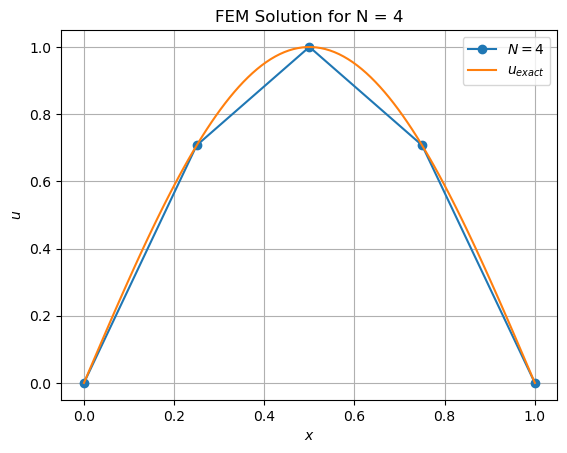

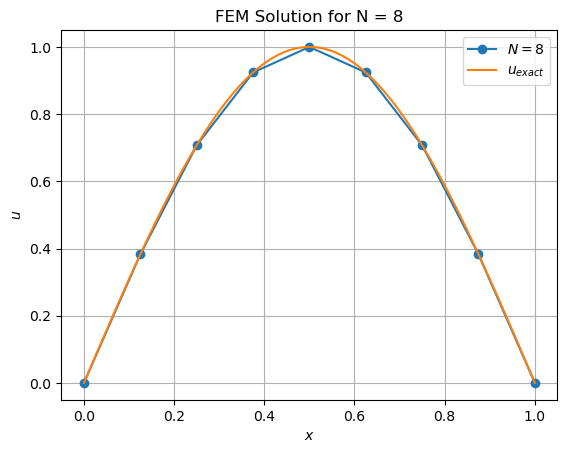

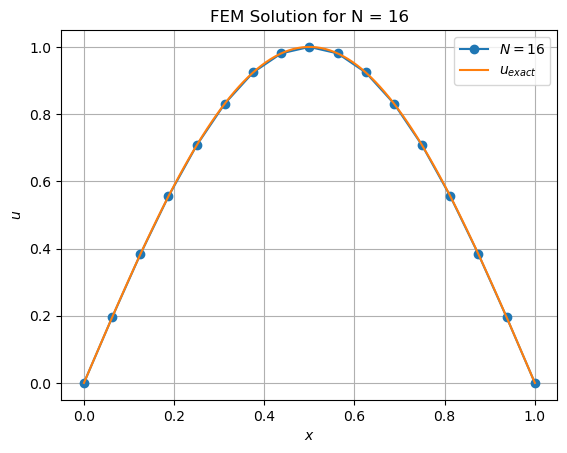

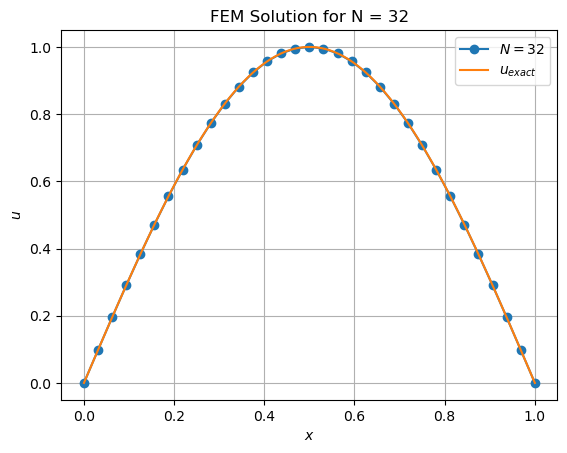

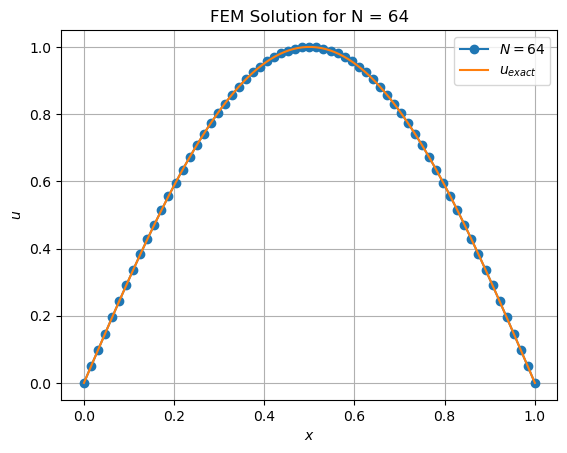

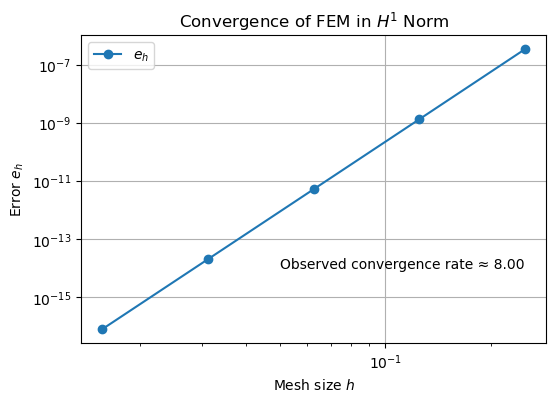

In [61]:

hs = []
errors = []

# Loop over different mesh sizes and compute errors
for N in [4, 8, 16, 32, 64]:
    geometry, u_h, KK = solve(N)
    u_exact = np.sin(np.pi * geometry).flatten()
    error_vec = u_exact - u_h
    e_h = error_vec.T @ KK @ error_vec
    hs.append(1 / N)
    errors.append(float(e_h))  # Ensure scalar, not array


# Compute slope of log-log error curve
slope = np.polyfit(np.log(hs), np.log(errors), 1)[0]

# Plot error vs h
plt.figure(figsize=(6,4))
plt.loglog(hs, errors, marker='o', label="$e_h$")
plt.xlabel("Mesh size $h$")
plt.ylabel("Error $e_h$")
plt.title("Convergence of FEM in $H^1$ Norm")
plt.text(5e-2,1e-14,f"Observed convergence rate ≈ {slope:.2f}")
plt.grid(True)
plt.legend()

